In [12]:
import numpy as np
import torch
from collections import Counter
import matplotlib.pyplot as plt
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

from src.encoding.configs_and_constants import ZINC_SMILES_HRR_1024_F64_5G1NG4_CONFIG, ZINC_SMILES_HRR_7744_CONFIG_F64
from src.encoding.graph_encoders import load_or_create_hypernet
from src.utils.utils import GLOBAL_MODEL_PATH


def analyze_dataset(ds: Dataset, name: str = "", feature_attr: str = "x") -> dict:
    """
    Compute statistics for a PyG dataset with 4-tuple node features
    and draw histograms for node counts, edge counts, and node-type distribution.
    """
    num_nodes_list, num_edges_list = [], []
    node_type_counter = Counter()
    logp_list: list[float] = []  # <-- collect logP if available

    for data in ds:
        n = int(data.num_nodes)
        e = int(data.num_edges) // 2  # dataset is undirected
        num_nodes_list.append(n)
        num_edges_list.append(e)

        x: torch.Tensor = getattr(data, feature_attr)
        if x.dim() != 2 or x.size(1) != 4:
            raise ValueError(f"Expected {feature_attr} shape [N, 4], got {tuple(x.shape)}")
        rows = x.detach().cpu().to(torch.int64).tolist()
        node_type_counter.update(map(tuple, rows))

        # --- logP (optional) ---
        if hasattr(data, "logp"):
            lp = data.logp
            # accept scalar tensor or 1-element tensor
            if isinstance(lp, torch.Tensor):
                lp = float(lp.detach().cpu().reshape(-1)[0])
            else:
                lp = float(lp)
            logp_list.append(lp)

    def stats(arr):
        arr = np.asarray(arr)
        return {
            "min": int(arr.min()),
            "max": int(arr.max()),
            "mean": float(arr.mean()),
            "median": float(np.median(arr)),
            "std": float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
        }

    summary = {
        "dataset": name,
        "num_graphs": len(ds),
        "nodes": stats(num_nodes_list),
        "edges": stats(num_edges_list),
        "total_node_types": len(node_type_counter),
        "node_type_distribution": dict(node_type_counter),
    }

    if logp_list:
        summary["logp"] = stats(logp_list)  # include logP stats if present


    # --- plotting ---
    fig = plt.figure(figsize=(16, 10))  # wider and taller canvas
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 3])  # bottom row 3x taller

    ax_nodes = fig.add_subplot(gs[0, 0])
    ax_edges = fig.add_subplot(gs[0, 1])
    ax_types = fig.add_subplot(gs[1, :])  # spans the whole width

    # Add a little more margin at the bottom so rotated labels fit
    plt.subplots_adjust(bottom=0.25)

    # Node count distribution
    ax_nodes.hist(num_nodes_list, bins=20, color="steelblue", edgecolor="black")
    ax_nodes.set_title(f"{name} – Node count distribution")
    ax_nodes.set_xlabel("num_nodes")
    ax_nodes.set_ylabel("frequency")

    # Edge count distribution
    ax_edges.hist(num_edges_list, bins=40, color="darkorange", edgecolor="black")
    ax_edges.set_title(f"{name} – Edge count distribution")
    ax_edges.set_xlabel("num_edges")
    ax_edges.set_ylabel("frequency")

    # Node type distribution (wider)
    if node_type_counter:
        labels, counts = zip(*node_type_counter.most_common())
        ax_types.bar(range(len(labels)), counts, color="seagreen", edgecolor="black")
        ax_types.set_xticks(range(len(labels)))
        ax_types.set_xticklabels([str(l) for l in labels], rotation=90, fontsize=8)
    ax_types.set_title(f"{name} – Node type distribution")
    ax_types.set_xlabel("node type (tuple)")
    ax_types.set_ylabel("count")

    plt.tight_layout()
    plt.show()

    # --- separate logP plot (only if available) ---
    if logp_list:
        fig2 = plt.figure(figsize=(8, 5))
        ax_logp = fig2.add_subplot(1, 1, 1)
        ax_logp.hist(logp_list, bins=100, edgecolor="black")
        ax_logp.set_title(f"{name} – logP distribution")
        ax_logp.set_xlabel("cLogP (RDKit)")
        ax_logp.set_ylabel("frequency")
        plt.tight_layout()
        plt.show()

    return summary


In [2]:
from pprint import pprint
from src.datasets.zinc_smiles_generation import ZincSmiles

for split in ["train", "valid", "test"]:
    ds = ZincSmiles(split=split)
    stats = analyze_dataset(ds, name=split)
    pprint(stats)

ValueError: Expected x shape [N, 4], got (33, 5)

In [ ]:
import torchhd
from src.datasets.zinc_smiles_generation import ZincSmiles
import torch
ds = ZincSmiles(split="train", enc_suffix="HRR7744")

# Number of samples
n_samples = 1000

# Ensure reproducibility
idxs = torch.randperm(len(ds))[:n_samples]
device = torch.device("cpu")
config = ZINC_SMILES_HRR_7744_CONFIG_F64
config.device = device
hypernet = load_or_create_hypernet(path=GLOBAL_MODEL_PATH, cfg=ZINC_SMILES_HRR_7744_CONFIG_F64).to(device)

for d in [2, 3, 4, 5, 6, 7, 8]:
    hypernet.depth = d
    batch = next(iter(DataLoader(ds[idxs], batch_size=n_samples)))

    graph_terms = hypernet.forward(batch)["graph_embedding"]
    print(graph_terms.shape)

    # Pairwise cosine similarity matrix [1000, 1000]
    cos = torchhd.cos(graph_terms, graph_terms)

    # keep only unique, off-diagonal cosine similarities
    i, j = torch.triu_indices(cos.size(0), cos.size(1), offset=1)
    cs = cos[i, j]  # shape [N*(N-1)/2]

    # compute stats
    mean_cs = cs.mean().item()
    std_cs = cs.std(unbiased=True).item()

    print(f"Mean cosine similarity: {mean_cs:.4f}")
    print(f"Std  cosine similarity: {std_cs:.4f}")

    # plot
    plt.figure(figsize=(6, 4))
    plt.hist(cs.cpu().numpy(), bins=50, density=True, alpha=0.75)
    plt.xlabel("Cosine similarity")
    plt.ylabel("Density")
    plt.title(f"Pairwise cosine similarities (Zinc - MP Depth {d}) \nμ={mean_cs:.3f}, σ={std_cs:.3f}")
    plt.tight_layout()
    plt.show()


Dataset Config: ZincSmilesHRR1024F645G1NG4

Loading existing HyperNet from /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_ZincSmilesHRR1024F645G1NG4_HRR_dim1024_s42_depth3_ecb0-f64.pt


/home/akaveh/Projects/kit/graph_hdc/.pixi/envs/local/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


torch.Size([1000, 1024])
Depth 2
  Mean cosine similarity: 0.4855 (σ=0.1909)
  Mean Tanimoto distance: 0.6757 (σ=0.1594)
  Pearson correlation: -0.9774 (p=0.00e+00)
  Spearman correlation: -0.9892 (p=0.00e+00)



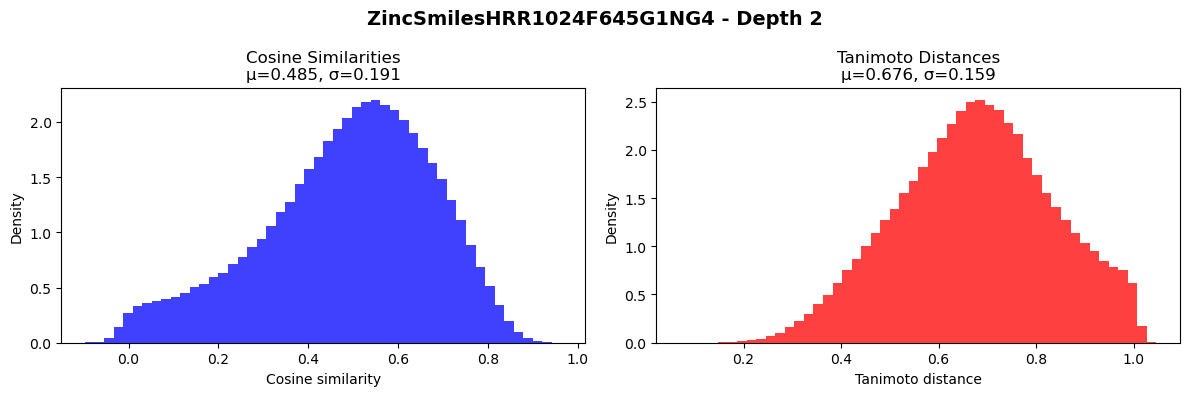

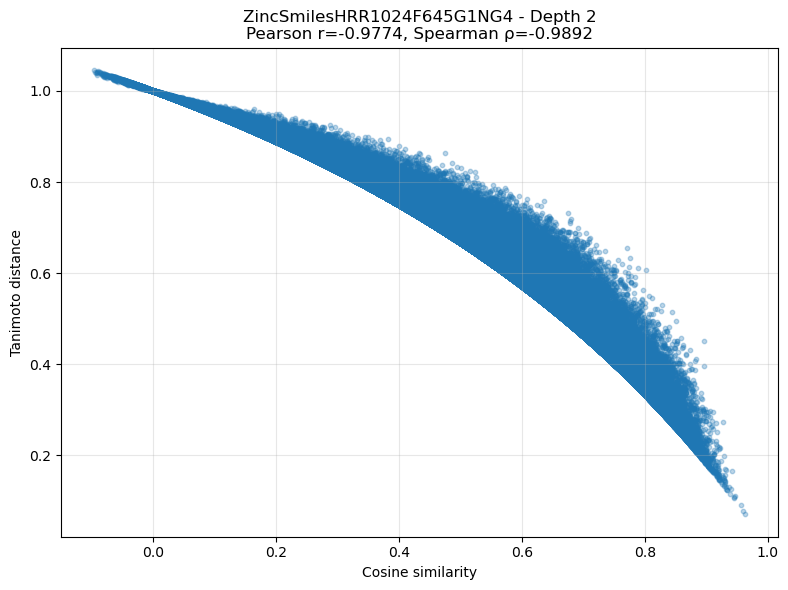

torch.Size([1000, 1024])
Depth 3
  Mean cosine similarity: 0.4243 (σ=0.1804)
  Mean Tanimoto distance: 0.7266 (σ=0.1421)
  Pearson correlation: -0.9820 (p=0.00e+00)
  Spearman correlation: -0.9922 (p=0.00e+00)



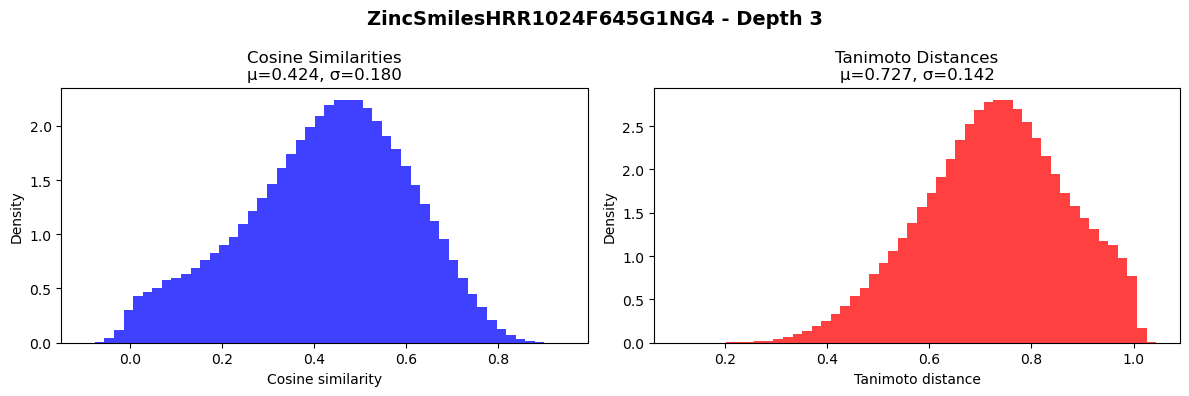

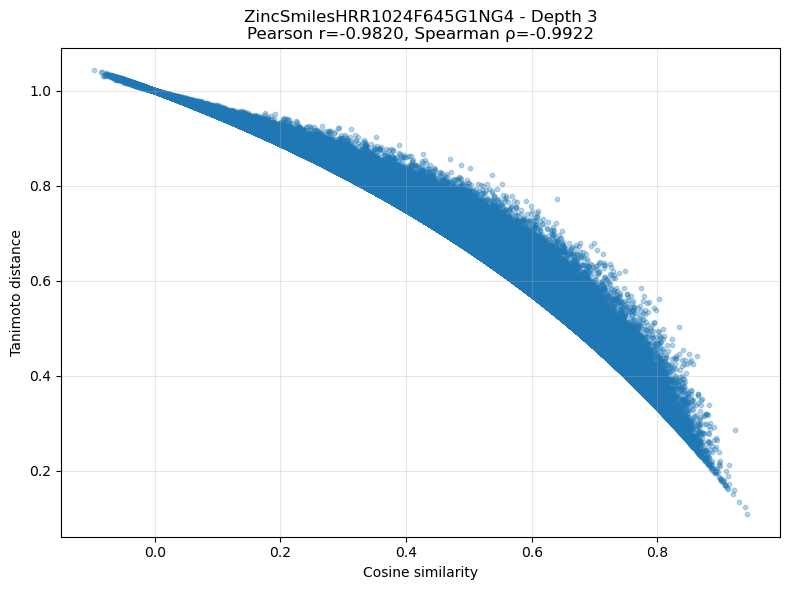

torch.Size([1000, 1024])
Depth 4
  Mean cosine similarity: 0.3923 (σ=0.1821)
  Mean Tanimoto distance: 0.7519 (σ=0.1392)
  Pearson correlation: -0.9825 (p=0.00e+00)
  Spearman correlation: -0.9927 (p=0.00e+00)



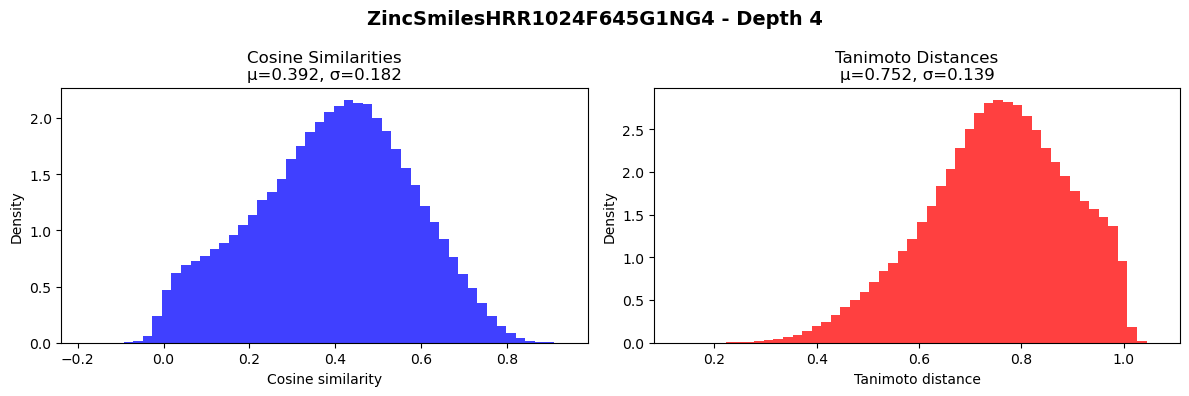

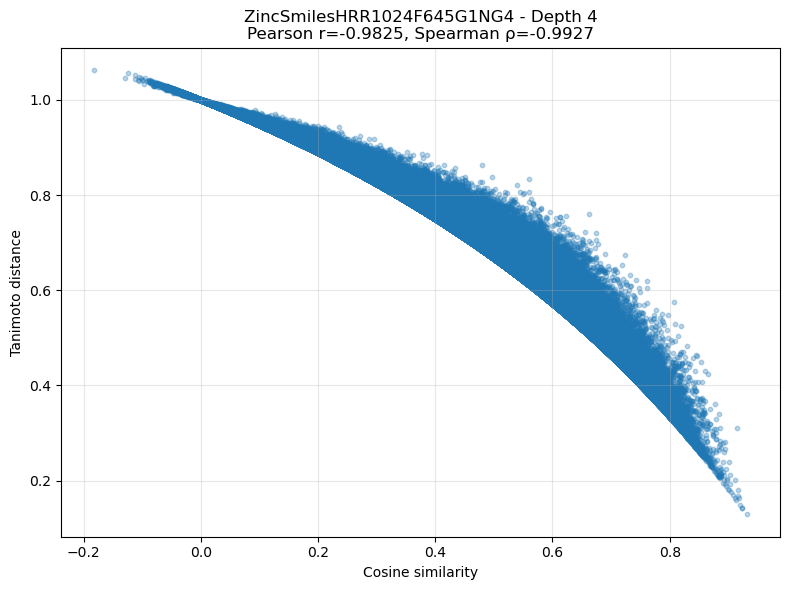

torch.Size([1000, 1024])
Depth 5
  Mean cosine similarity: 0.3682 (σ=0.1886)
  Mean Tanimoto distance: 0.7697 (σ=0.1416)
  Pearson correlation: -0.9828 (p=0.00e+00)
  Spearman correlation: -0.9935 (p=0.00e+00)



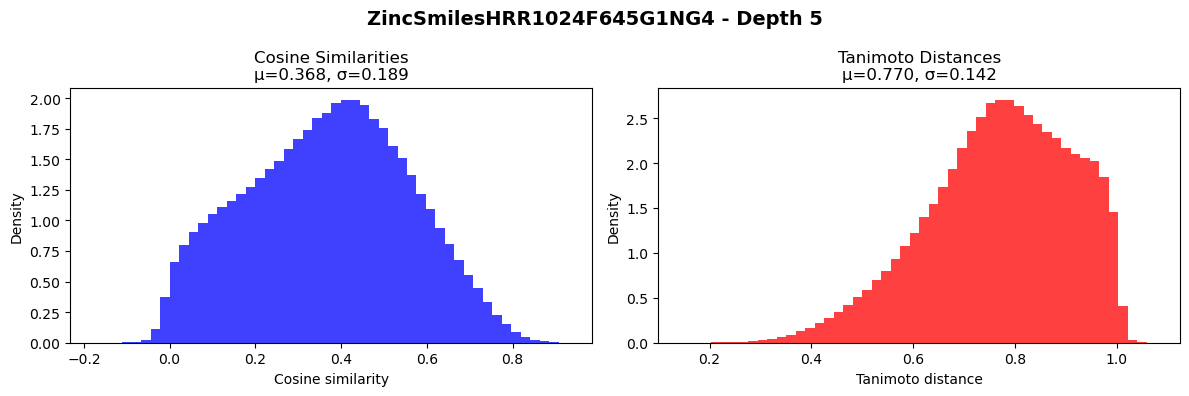

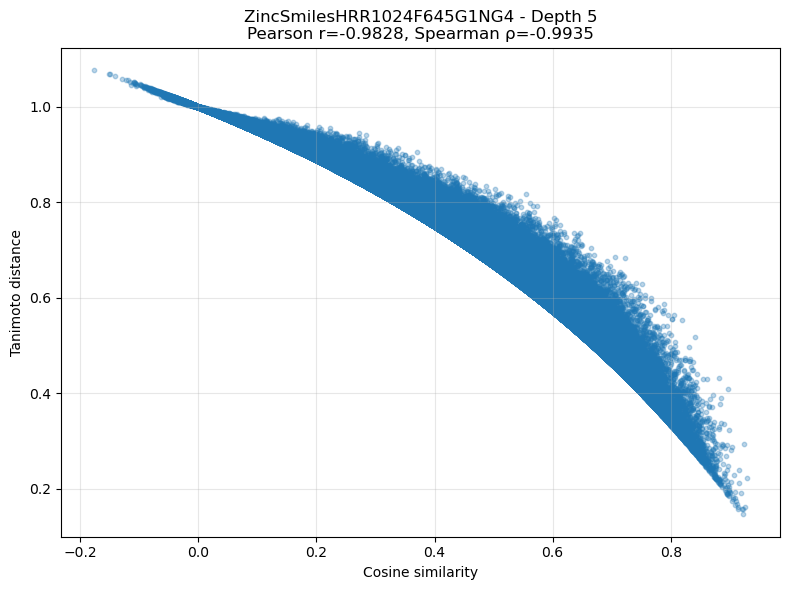

torch.Size([1000, 1024])
Depth 6
  Mean cosine similarity: 0.3450 (σ=0.1953)
  Mean Tanimoto distance: 0.7868 (σ=0.1444)
  Pearson correlation: -0.9817 (p=0.00e+00)
  Spearman correlation: -0.9934 (p=0.00e+00)



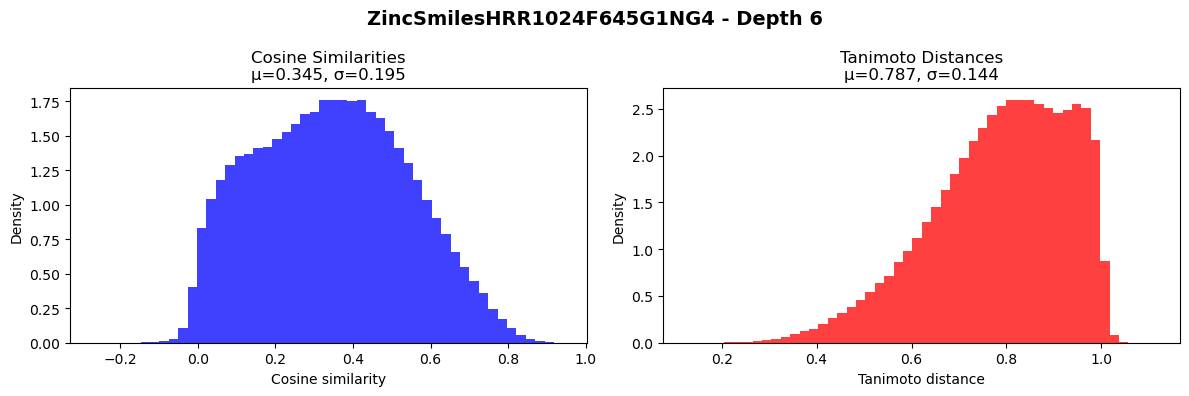

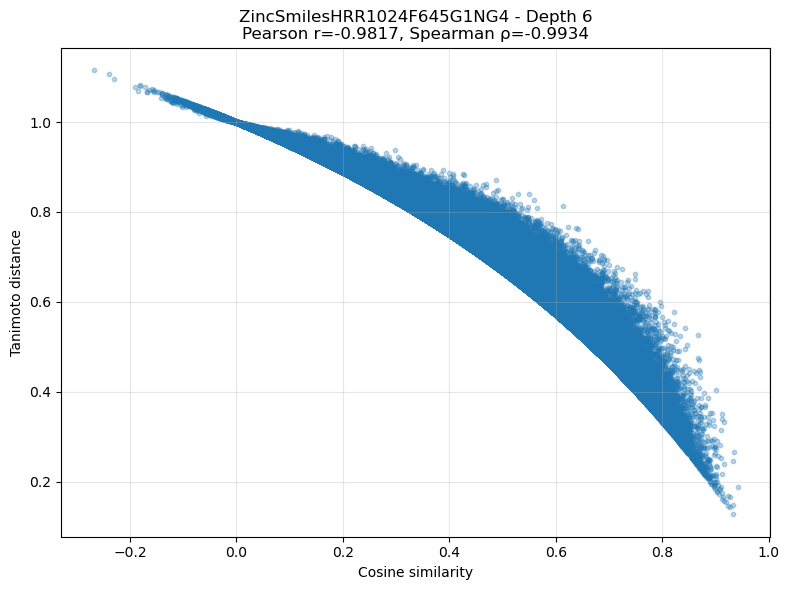

torch.Size([1000, 1024])
Depth 7
  Mean cosine similarity: 0.3161 (σ=0.1895)
  Mean Tanimoto distance: 0.8081 (σ=0.1371)
  Pearson correlation: -0.9821 (p=0.00e+00)
  Spearman correlation: -0.9941 (p=0.00e+00)



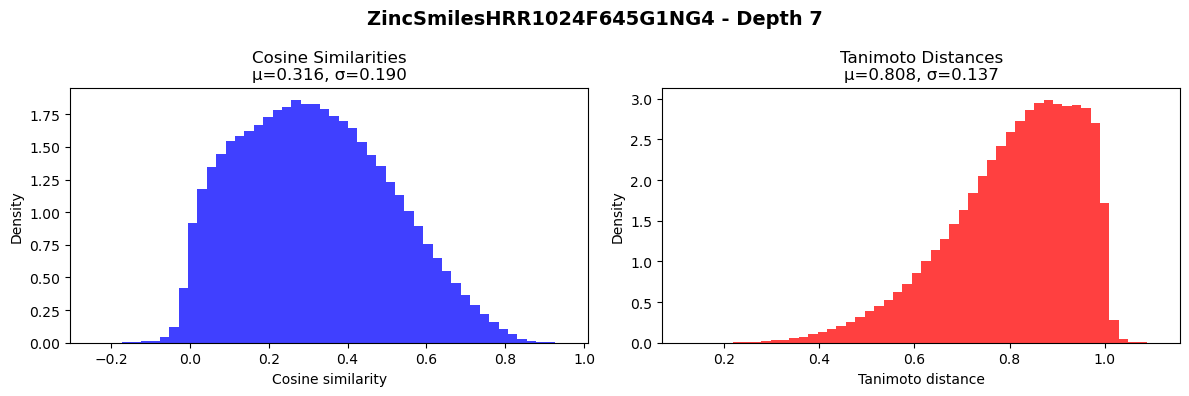

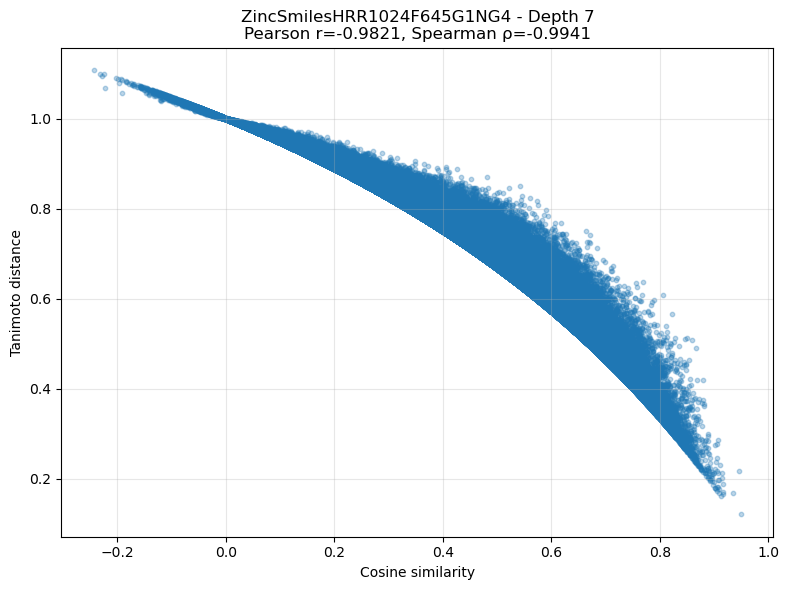

torch.Size([1000, 1024])
Depth 8
  Mean cosine similarity: 0.2990 (σ=0.1856)
  Mean Tanimoto distance: 0.8207 (σ=0.1317)
  Pearson correlation: -0.9824 (p=0.00e+00)
  Spearman correlation: -0.9942 (p=0.00e+00)



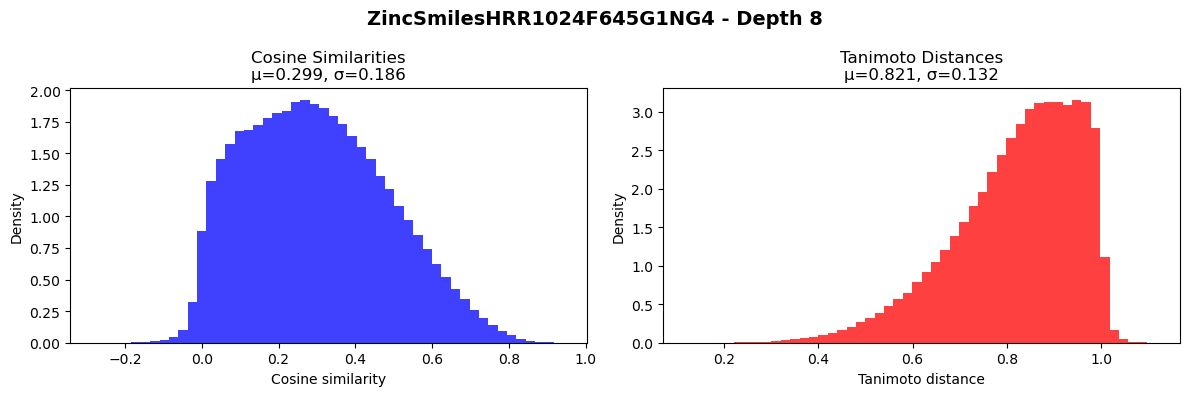

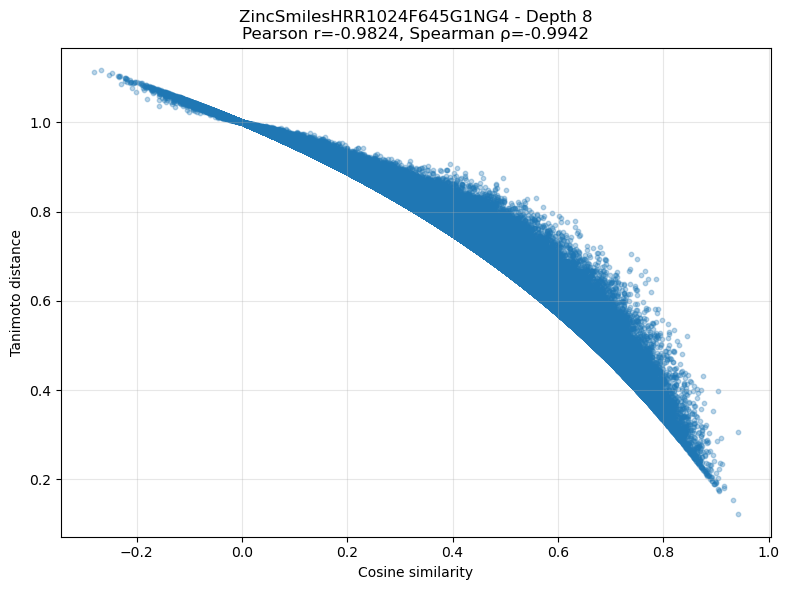


Dataset Config: ZincSmilesHRR2048F645G1NG4

Creating new HyperNet instance.
Saved new HyperNet to /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_ZincSmilesHRR2048F645G1NG4_HRR_dim2048_s42_depth3_ecb0-f64.pt
torch.Size([1000, 2048])
Depth 2
  Mean cosine similarity: 0.4925 (σ=0.1908)
  Mean Tanimoto distance: 0.6686 (σ=0.1599)
  Pearson correlation: -0.9781 (p=0.00e+00)
  Spearman correlation: -0.9894 (p=0.00e+00)



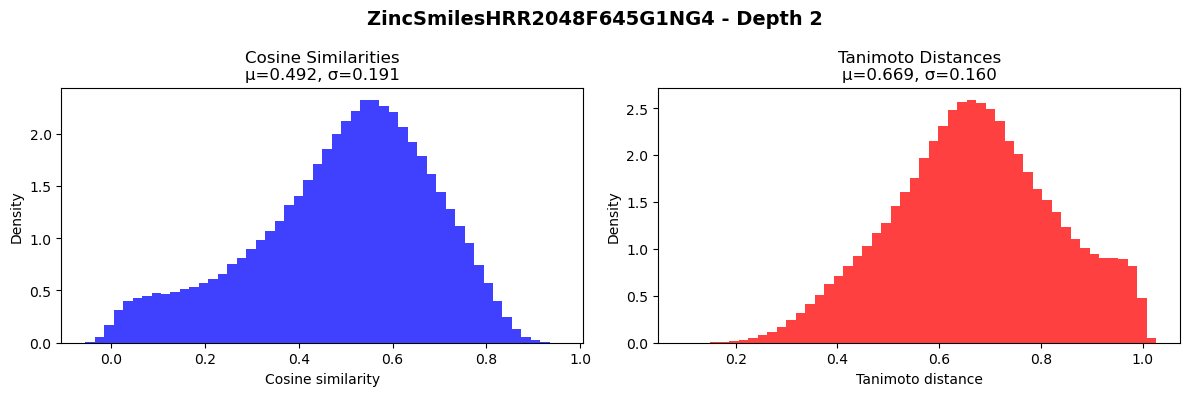

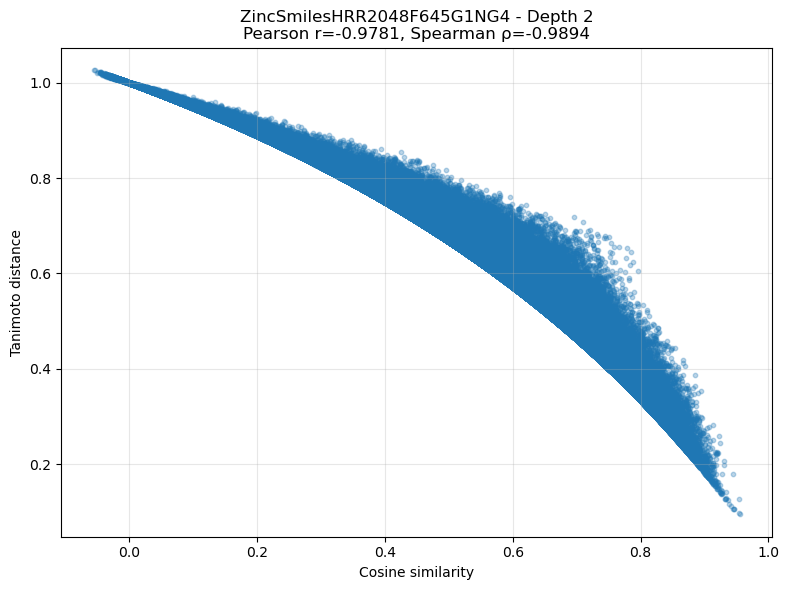

torch.Size([1000, 2048])
Depth 3
  Mean cosine similarity: 0.4313 (σ=0.1765)
  Mean Tanimoto distance: 0.7196 (σ=0.1401)
  Pearson correlation: -0.9837 (p=0.00e+00)
  Spearman correlation: -0.9937 (p=0.00e+00)



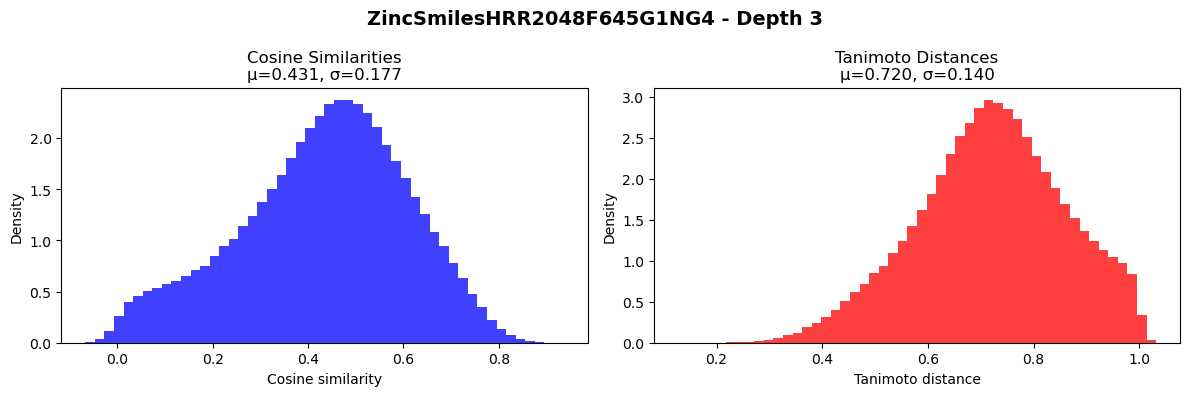

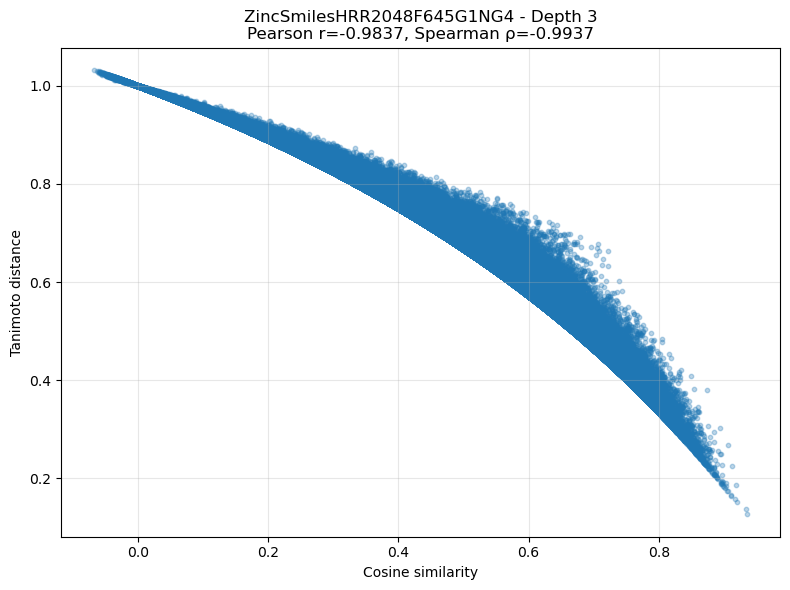

torch.Size([1000, 2048])
Depth 4
  Mean cosine similarity: 0.3768 (σ=0.1819)
  Mean Tanimoto distance: 0.7618 (σ=0.1385)
  Pearson correlation: -0.9850 (p=0.00e+00)
  Spearman correlation: -0.9955 (p=0.00e+00)



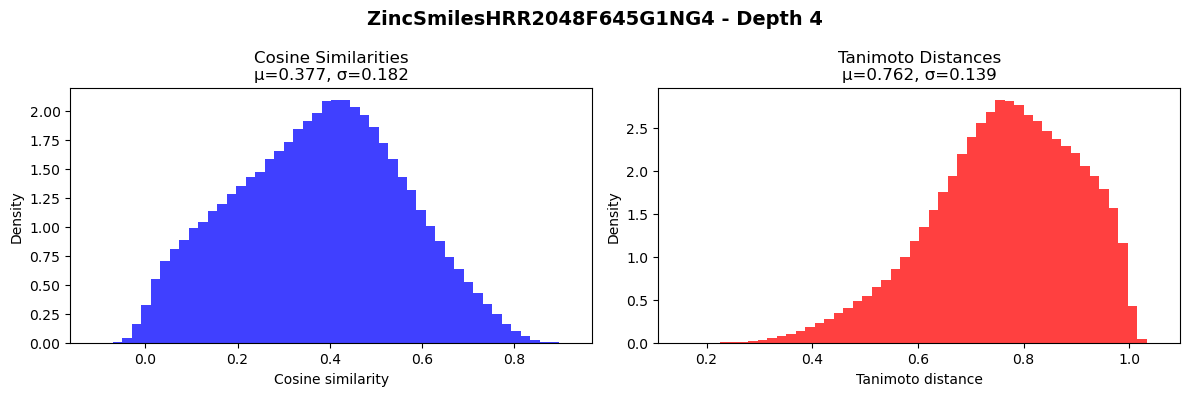

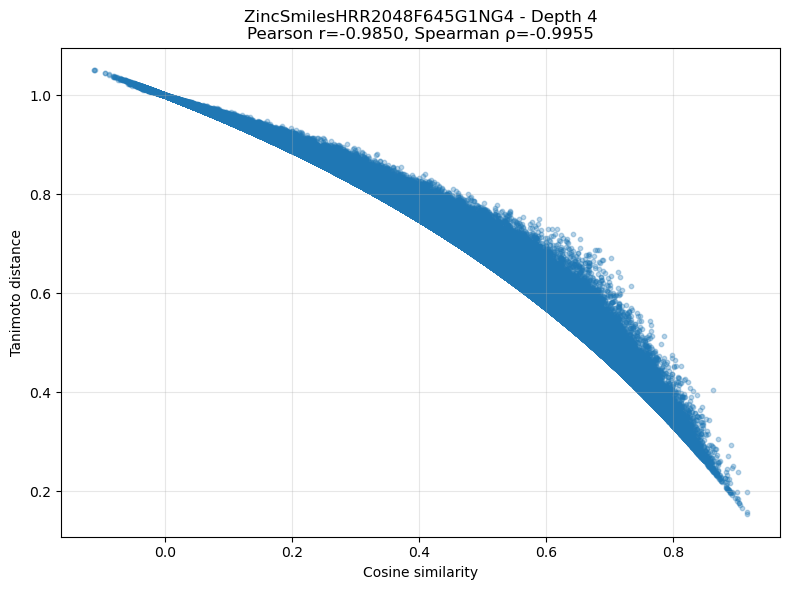

torch.Size([1000, 2048])
Depth 5
  Mean cosine similarity: 0.3237 (σ=0.1837)
  Mean Tanimoto distance: 0.8011 (σ=0.1340)
  Pearson correlation: -0.9850 (p=0.00e+00)
  Spearman correlation: -0.9961 (p=0.00e+00)



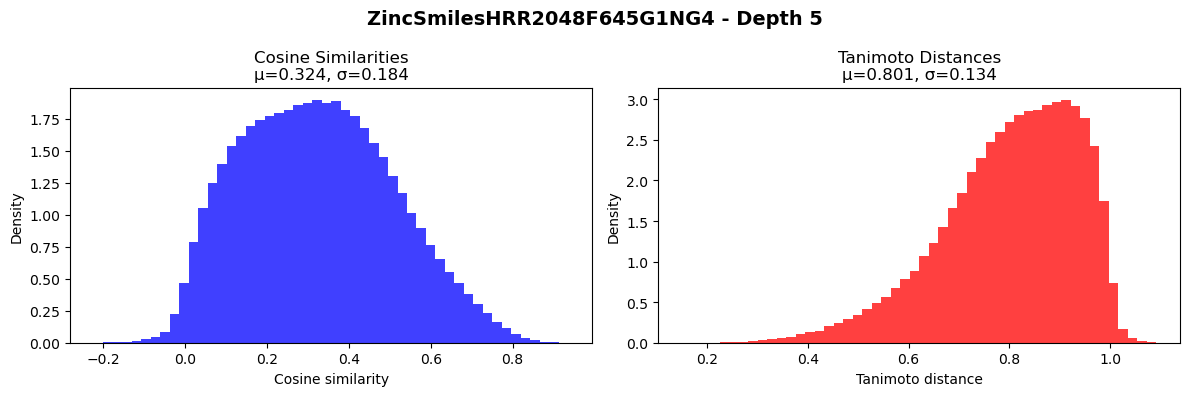

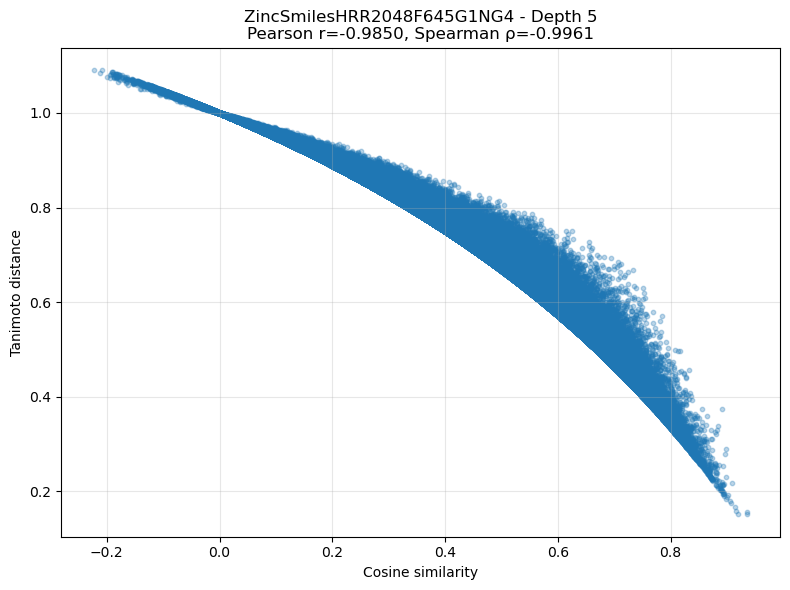

torch.Size([1000, 2048])
Depth 6
  Mean cosine similarity: 0.2930 (σ=0.1757)
  Mean Tanimoto distance: 0.8238 (σ=0.1246)
  Pearson correlation: -0.9848 (p=0.00e+00)
  Spearman correlation: -0.9958 (p=0.00e+00)



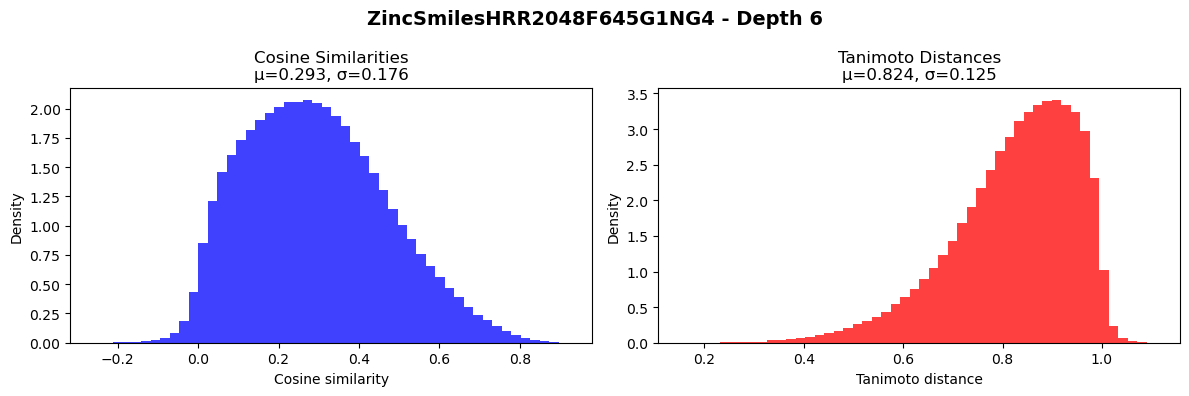

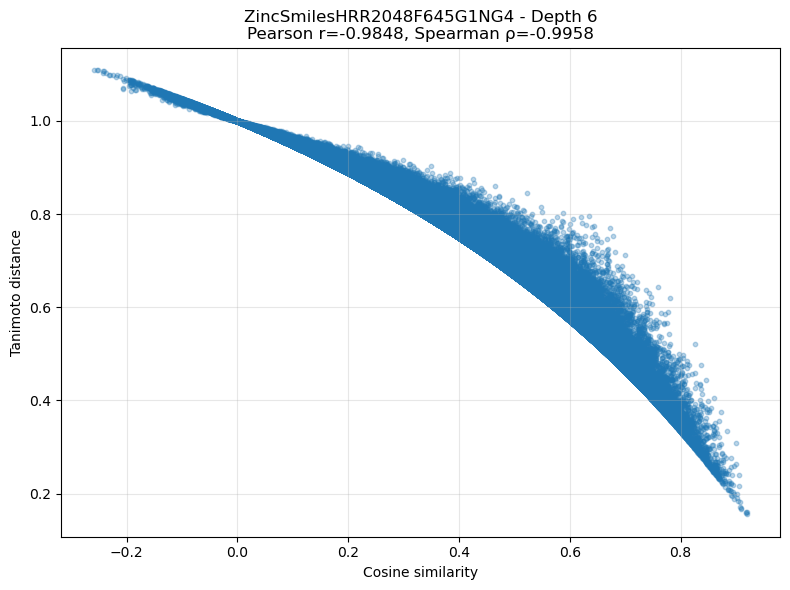

torch.Size([1000, 2048])
Depth 7
  Mean cosine similarity: 0.2795 (σ=0.1759)
  Mean Tanimoto distance: 0.8329 (σ=0.1231)
  Pearson correlation: -0.9847 (p=0.00e+00)
  Spearman correlation: -0.9960 (p=0.00e+00)



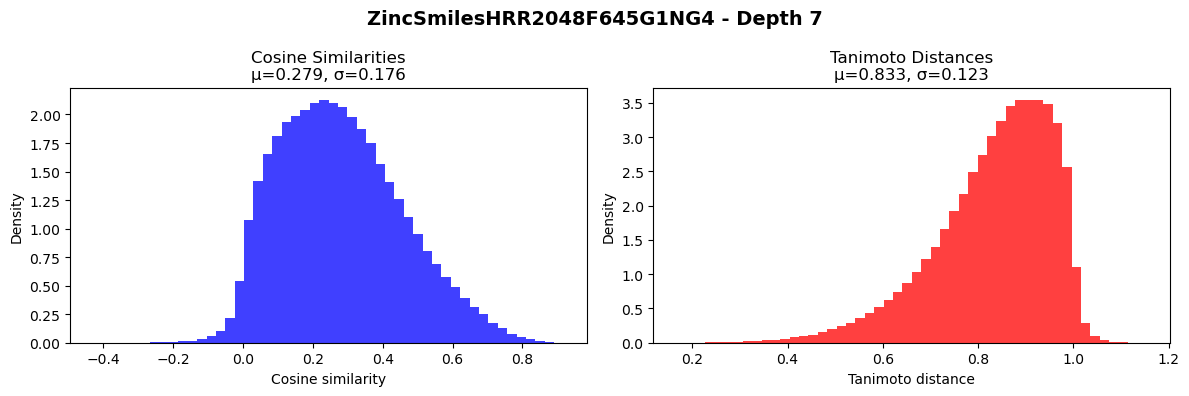

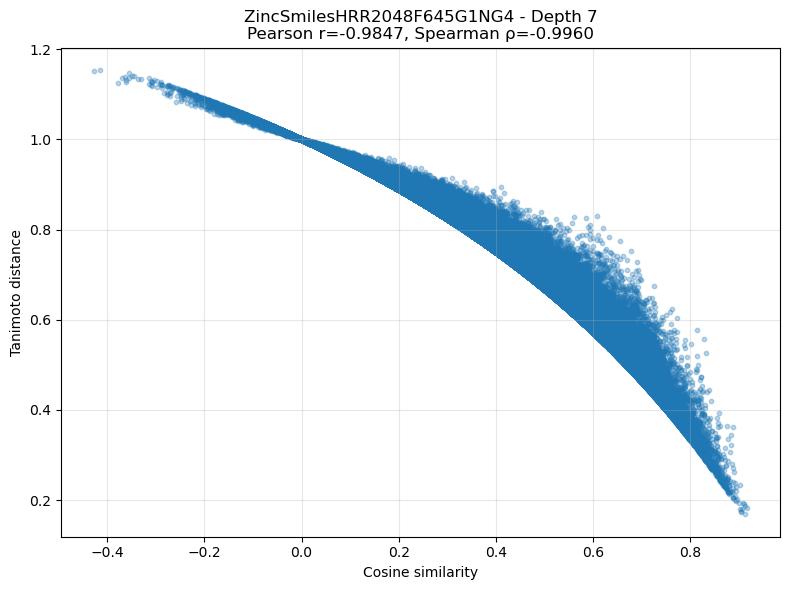

torch.Size([1000, 2048])
Depth 8
  Mean cosine similarity: 0.2586 (σ=0.1746)
  Mean Tanimoto distance: 0.8470 (σ=0.1199)
  Pearson correlation: -0.9844 (p=0.00e+00)
  Spearman correlation: -0.9961 (p=0.00e+00)



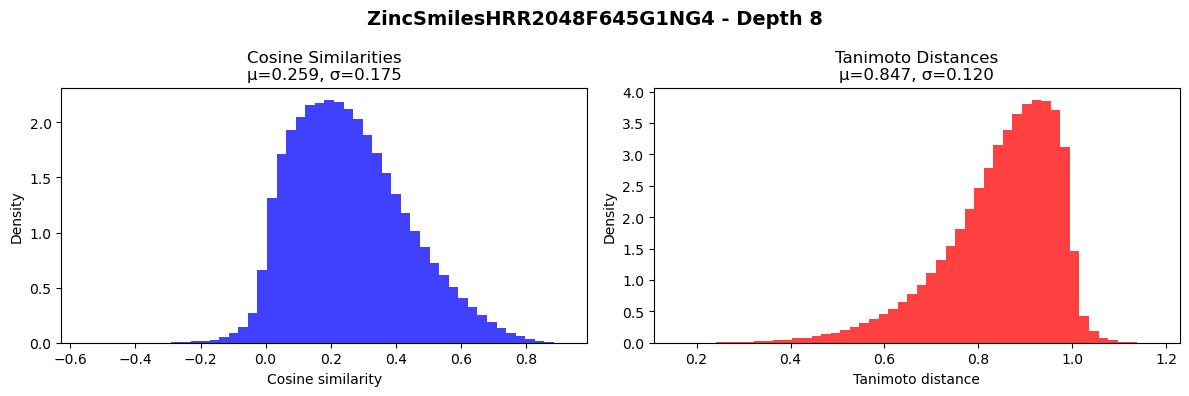

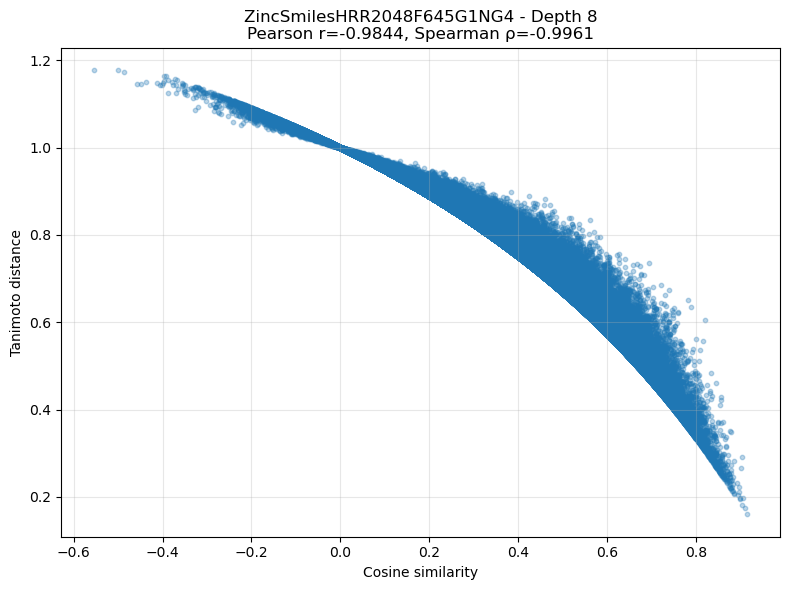

In [11]:
import torchhd
from src.datasets.zinc_smiles_generation import ZincSmiles
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from src.encoding.configs_and_constants import ZINC_SMILES_HRR_1024_F64_5G1NG4_CONFIG, ZINC_SMILES_HRR_2048_F64_5G1NG4_CONFIG

# Number of samples
n_samples = 1000

# Ensure reproducibility
device = torch.device("cpu")

for ds_config in [
    ZINC_SMILES_HRR_1024_F64_5G1NG4_CONFIG,
    ZINC_SMILES_HRR_2048_F64_5G1NG4_CONFIG
]:
    print(f"\n{'='*60}")
    print(f"Dataset Config: {ds_config.name}")
    print(f"{'='*60}\n")

    ds = ZincSmiles(split="train")

    idxs = torch.randperm(len(ds))[:n_samples]
    ds_config.device = device
    hypernet = load_or_create_hypernet(path=GLOBAL_MODEL_PATH, cfg=ds_config).to(device)

    for d in [2, 3, 4, 5, 6, 7, 8]:
        hypernet.depth = d
        batch = next(iter(DataLoader(ds[idxs], batch_size=n_samples)))

        graph_terms = hypernet.forward(batch)["graph_embedding"]
        print(graph_terms.shape)

        # Pairwise cosine similarity matrix [1000, 1000]
        cos = torchhd.cos(graph_terms, graph_terms)

        # Keep only unique, off-diagonal cosine similarities
        i, j = torch.triu_indices(cos.size(0), cos.size(1), offset=1)
        cs = cos[i, j]  # shape [N*(N-1)/2]

        # Compute Tanimoto distance
        # Tanimoto distance = 1 - (A·B) / (||A||² + ||B||² - A·B)
        dot_product = torch.mm(graph_terms, graph_terms.t())
        norm_sq = torch.sum(graph_terms ** 2, dim=1, keepdim=True)

        # Pairwise Tanimoto distances
        tanimoto_dist = torch.zeros_like(cos)
        for ii in range(graph_terms.size(0)):
            for jj in range(graph_terms.size(0)):
                dot = dot_product[ii, jj]
                denom = norm_sq[ii, 0] + norm_sq[jj, 0] - dot
                tanimoto_dist[ii, jj] = 1 - (dot / (denom + 1e-8))

        # Extract upper triangle
        td = tanimoto_dist[i, j]  # shape [N*(N-1)/2]

        # Compute stats
        mean_cs = cs.mean().item()
        std_cs = cs.std(unbiased=True).item()
        mean_td = td.mean().item()
        std_td = td.std(unbiased=True).item()

        # Compute correlation
        pearson_corr, pearson_p = pearsonr(cs.cpu().numpy(), td.cpu().numpy())
        spearman_corr, spearman_p = spearmanr(cs.cpu().numpy(), td.cpu().numpy())

        print(f"Depth {d}")
        print(f"  Mean cosine similarity: {mean_cs:.4f} (σ={std_cs:.4f})")
        print(f"  Mean Tanimoto distance: {mean_td:.4f} (σ={std_td:.4f})")
        print(f"  Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.2e})")
        print(f"  Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.2e})")
        print()

        # Plot: histogram comparison
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        axes[0].hist(cs.cpu().numpy(), bins=50, density=True, alpha=0.75, color='blue')
        axes[0].set_xlabel("Cosine similarity")
        axes[0].set_ylabel("Density")
        axes[0].set_title(f"Cosine Similarities\nμ={mean_cs:.3f}, σ={std_cs:.3f}")

        axes[1].hist(td.cpu().numpy(), bins=50, density=True, alpha=0.75, color='red')
        axes[1].set_xlabel("Tanimoto distance")
        axes[1].set_ylabel("Density")
        axes[1].set_title(f"Tanimoto Distances\nμ={mean_td:.3f}, σ={std_td:.3f}")

        fig.suptitle(f"{ds_config.name} - Depth {d}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Plot: scatter plot showing correlation
        plt.figure(figsize=(8, 6))
        plt.scatter(cs.cpu().numpy(), td.cpu().numpy(), alpha=0.3, s=10)
        plt.xlabel("Cosine similarity")
        plt.ylabel("Tanimoto distance")
        plt.title(f"{ds_config.name} - Depth {d}\nPearson r={pearson_corr:.4f}, Spearman ρ={spearman_corr:.4f}")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()